In [ ]:
# default_exp nnsig

### Neural network using numpy
#### works on cpu only if there's no pyopencl and else

In [ ]:
#export
import numpy as np

In [ ]:
# import matplotlib.pyplot as plt
# define plotting functions for productivity, wouldn't you

#### fetch dataset

In [ ]:
#export
def fetch(url):
    import requests, hashlib, os, tempfile
    fp = os.path.join(tempfile.gettempdir(), hashlib.md5(url.encode('utf-8')).hexdigest())

    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    
    else:
        dat = requests.get(url).content
        with open(fp + ".tmp", "wb") as f:
            f.write(dat)
        
        os.rename(fp+".tmp", fp)
    
    return dat

In [ ]:
#export
def mnist(url1="http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", url2="http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz", url3="http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", url4="http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"):
    # from geohot
    import gzip
    import numpy as np

    def parse(dat): return np.frombuffer(
        gzip.decompress(dat), dtype=np.uint8).copy()

    X_train = parse(fetch(url1))[0x10:].reshape((-1, 28, 28))
    Y_train = parse(fetch(url2))[8:]
    X_test = parse(fetch(url3))[0x10:].reshape((-1, 28, 28))
    Y_test = parse(fetch(url4))[8:]
    return X_train, Y_train, X_test, Y_test


#### import mnist dataset

In [ ]:
x_train,y_train,x_test,y_test = mnist()
x_train.shape

(60000, 28, 28)

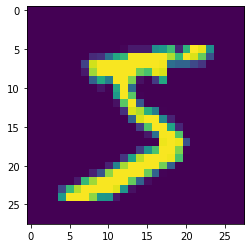

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(x_train[0])
plt.show()

### Should set type to float32 / 16 ?

#### utils function

In [ ]:
#export 
# inits
# add "t" dimension for convolution, not tested
def kaiming_uniform(h,w,t=None):
    if t is None:
        return np.random.uniform(-1.,1.,size=(h,w))/np.sqrt(h*w)
    else:
        return np.random.uniform(-1.,1.,size=(h,w,t))/np.sqrt(h*w)

# ref to pytorch to see how gain is calculated
# not tested
def kaiming_normal(h,w,gain=1):
    return np.random.randn(h,w)/np.sqrt(2./h)*gain

In [ ]:
kaiming_uniform(2,3,4)

array([[[-0.21228465,  0.24765315, -0.25268094],
        [-0.23144798, -0.04920292,  0.17055164]],

       [[-0.13963562, -0.2088165 ,  0.37593109],
        [ 0.38059491,  0.26098882,  0.02037893]],

       [[-0.03300621,  0.11673715, -0.06747579],
        [ 0.37649997,  0.3338308 , -0.01365257]],

       [[ 0.09447013, -0.03462322, -0.23229127],
        [ 0.40166175, -0.15867257,  0.31534735]]])

In [ ]:
x = np.array([[1,2],[3,4]])
x.mean(axis=0), x.mean(axis=1)

(array([2., 3.]), array([1.5, 3.5]))

In [ ]:
# export 
def stat(x):
    """ get standard deviation and mean of matrix x"""
    avg = x.mean()
    std = np.square(x - avg).mean()
    return avg, std

In [ ]:
stat(x)

(2.5, 1.25)

In [ ]:
x[None], x

(array([[[1, 2],
         [3, 4]]]),
 array([[1, 2],
        [3, 4]]))

In [ ]:
# see if std of init weight = 1 ?


## Try to add __ repr __ and dict 
#### To store the layers and therefore more customizable, also, enable to save the weights much more convenient
#### 

### Build the layers

In [ ]:
# export
class Linear:
    def __init__(self,h,w,init_fn = kaiming_uniform):
        self.weight = init_fn(h,w)
        self.grad = np.zeros((h,w))
        self.fpass = None
    
    def forward(self,x):
        out = x @ self.weight
        self.fpass = x
        return out
    
    def backward(self,bpass):
        self.grad = (self.fpass.T) @ bpass
        # without returning it, it doesn't work
        # bpass = bpass @ (self.weight.T)

In [ ]:
one = Linear(784,128)
one.weight[0,:5], one.weight.shape, one.forward(x_train[0:1].reshape(1,-1)).shape

(array([ 0.00153528,  0.00014511,  0.00023883, -0.00245906, -0.00111359]),
 (784, 128),
 (1, 128))

In [ ]:
one.fpass.shape, one.grad.shape

((1, 784), (784, 128))

#### Loss functions

In [ ]:
# export 
def MSELoss(yhat,y,num_class=10,supervised=True):
    if supervised:
        label = np.zeros((len(y), num_class), dtype=np.float32)
        label[range(label.shape[0]), y] = 1
        y = label
    val = np.square(yhat - y).mean(axis=0)
    grad = 2 * (yhat - y) / len(yhat)
    return val, grad

# can be achieved via NNL_Loss and softmax
def NNL():
    """ negative log likelihood """
    return

def CELoss(yhat,y):
    """ cross entropy loss"""
    return

In [ ]:
a = np.array([[1,2],[3,4]])
a.mean(axis=0), a.mean(axis=1), a.mean(axis=-1)

(array([2., 3.]), array([1.5, 3.5]), array([1.5, 3.5]))

### Optimizer 

In [ ]:
# export
def SGD(lr = 1e-3, model = None):
    for layer in model:
        layer.weight -= lr * layer.grad

def Adam():
    pass

### Build Sequential model class ?

In [ ]:
# export
class Sequential:
    # learn **kwargs
    def __init__(self,layers,lossfn,opt_fn):
        if not isinstance(layers,list):
            self.model = [layers]
        else:
            self.model = layers
        
        self.lossfn = lossfn
        self.opt_fn = opt_fn
    
    # check arguments when it comes to validation
    def forward(self,x):
        out = self.model[0].forward(x)
        for layer in self.model[1:]:
            out = layer.forward(out)
        return out

    def backward(self,grad):
        for layer in reversed(self.model):
            layer.backward(grad)
            grad = grad @ (layer.weight.T)

    def fit(self,x,y,epoch=1,batch_size=64,x_test=None,y_test=None):
        # loop thru len//bs
        losses = []
        ln = len(x)
        for _ in range(ln//batch_size):
            losses += self.fit_one_batch(x,y,epoch,batch_size,x_test,y_test)
        return losses

    def fit_one_batch(self,x,y,epoch=1,batch_size=64,x_test=None,y_test=None):
        # loop thru len//bs
        losses = []
        ln = len(x)
        for _ in range(epoch):
            idx = np.random.randint(0,ln,size=batch_size)
            x_ = x[idx].reshape((-1,28*28))
            y_ = y[idx]
            out = self.forward(x_)

            loss, grad = self.lossfn(out,y_)
            self.backward(grad)
            self.opt_fn(lr=1e-5, model=self.model)

            losses.append(loss.mean())
        
        return losses        


In [ ]:
# train for a epoch here
model = Sequential([Linear(784,128),Linear(128,10)],MSELoss,SGD)

In [ ]:
losses = model.fit(x_train,y_train,epoch=2)

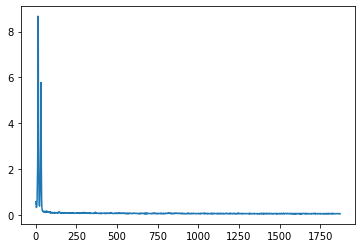

0.04187458886272651

In [ ]:
from matplotlib import pyplot as plt
plt.plot(list(range(len(losses))),losses)
plt.show()
losses[-1]

In [ ]:
""" It's correct now """
for i in range(10):
    print(np.argmax(model.forward(x_test[i:i+1].reshape((-1,28*28)))), y_test[i])

7 7
2 2
1 1
0 0
4 4
1 1
4 4
9 9
5 5
9 9


In [ ]:
# add accuracy first
# test passed, can add to model class
acc = 0
bs = 256

for i in range(0,x_test.shape[0],bs):
    acc += int((np.argmax(model.forward(x_test[i:i+bs].reshape((-1,28*28))),axis=-1) == y_test[i:i+bs]).sum())


print("accuracy is: %.4f" % (acc/(x_test.shape[0])))

accuracy is: 0.8298


## Shape: following NHWC

### Conv Layer

#### Check docs to see if there's is a different way to calculated gradient

In [ ]:
# export
# not tested
class Conv:
    def __init__(self,filters,kernelsize,padding=0,init_fn=kaiming_uniform):
        self.weight = np.zeros((kernelsize,kernelsize,filters))
        for f in self.weight:
            f = init_fn(kernelsize,kernelsize)
        self.grad = np.zeros((kernelsize,kernelsize,filter))
        self.fpass = None

    def forward(self,x):
        # take advantage of einsum for speed and simplicity
        # assume x.shape[0] == x.shape[1]
        # ...
        return

    def backward(self,grad):
        # transpose weight to calculate gradient ?
        return 

In [ ]:
import numpy as np

In [ ]:
(28-3)//2+1

13

In [ ]:
#export
# naive function of convolution
def naive(f,x,st=2,ks=3):
    out = np.zeros((((x.shape[0]-ks)//st+1),((x.shape[1]-ks)//st+1)))
    for i in range(0,x.shape[0]-1,st):
        for j in range(0,x.shape[1]-1,st):
            # for debug
            # print(i,":",i+ks,"->",j,":",j+ks)
            # print(x[i:i+ks,j:j+ks])
            print(f.shape,x[i:i+ks,j:j+ks].shape)
            out[i//st,j//st] = np.multiply(f,x[i:i+ks,j:j+ks]).sum()
    
    return out


In [ ]:
naive(np.arange(9).reshape(3,3),np.arange(49).reshape(7,7))

array([[ 420.,  492.,  564.],
       [ 924.,  996., 1068.],
       [1428., 1500., 1572.]])

### Conv_dump
#### written for debugging & testing of Conv class
#### TODO:
####  
####  Adjust the inner/outer loop of forward() (actual ConvOps per se) -> loop thru the input only once (filter-first)

In [ ]:
# for not moving up and down
import numpy as np
from HWS.nnsig import kaiming_normal
from matplotlib import pyplot as plt

In [ ]:
# export
# can be used to test Conv class
# add Conv in naive way
class Conv_dump:
    def __init__(self,filters=1,kernelsize=3,stride=2,padding=0,init_fn=kaiming_uniform):
        self.f = init_fn(kernelsize,kernelsize,filters)
        self.grad = np.zeros((kernelsize,kernelsize,filters))
        self.fpass = None
        self.ks = kernelsize
        self.st = stride

    def forward(self,x):
        # pre cache, don't know if it's actually faster compare to refering to self.sth every time
        f = self.f
        ks = self.ks
        st = self.st

        out = np.zeros((((x.shape[0]-ks)//st+1),((x.shape[1]-ks)//st+1),f.shape[-1]))

        """ 
        About the loop: should try to reduce the time of walking thru input feature
        now: loop filters{loop thru input} ## SLOW
        faster version will be to loop thru every filter at the inner-est loop, then loop thru input
         , which will give us #walking thru = 1
        """
        ## DEBUG
        # now, it's slow
        for k in range(f.shape[-1]):
            out[:,:,k] = naive(f[:,:,k],x)

        self.fpass = x
        return out

    def backward(self,grad):
        # transpose weight to calculate gradient ?
        # loop
        #   x = input[i:i+ks,j:j+ks] # rth ks*ks matrix
        #   y = rth element in grad
        #   grad_per_step = x*y
        # convops
        # return it
        return grad

In [ ]:
b = np.random.uniform(-1.,1.,size=(27,27,1))
b.shape

(27, 27, 1)

In [ ]:
l = Conv_dump()
l.forward(b).shape

(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 

(13, 13, 1)

(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 

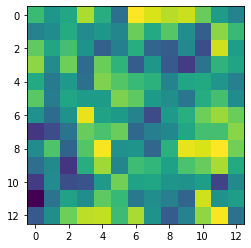

In [ ]:
plt.imshow(l.forward(b))

In [ ]:
naive??

Signature: naive(f, x, st=2, ks=3)
Docstring: <no docstring>
Source:   
def naive(f,x,st=2,ks=3):
    out = np.zeros((((x.shape[0]-ks)//st+1),((x.shape[1]-ks)//st+1)))
    for i in range(0,x.shape[0]-1,st):
        for j in range(0,x.shape[1]-1,st):
            # for debug
            # print(i,":",i+ks,"->",j,":",j+ks)
            # print(x[i:i+ks,j:j+ks])
            out[i//st,j//st] = np.multiply(f,x[i:i+ks,j:j+ks]).sum()
    
    return out
File:      c:\users\kelvin\documents\github\hws\<ipython-input-2-e8186fba8073>
Type:      function


In [ ]:
c = np.random.uniform(-1.,1.,size=(28,28,1))
plt.imshow(l.forward(c))

(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 3, 1)
(3, 3) (3, 2, 1)


ValueError: operands could not be broadcast together with shapes (3,3) (3,2,1) 

### Flatten / unsqueeze

#### I don't think this is the right way to do, since it requires way too much conditioning in the model class

In [ ]:
# export
# not tested: 90% certain it's correct
# we're only use library (numpy) 
# since it's slow to do computation in pure python
class Flatten:
    """
    reshape input to target shape
    """
    def __init__(self):
        self.shape=None

    def forward(self,x):
        """ 
        Should consider batch size
        image: (h,w,c) -> (b,h,w,c)
         flatten: (b,h*w*c)
        
        otherwise: 
        (b,d) -> (1, b*d)

        """
        self.shape = x.shape
        return x.reshape((1,-1))
    
    def backward(self,grad):
        return grad.reshape(self.shape)

In [ ]:
x = np.array([[1,2],[3,4]])
l = Flatten()
x, l.forward(x), l.backward(l.forward(x))

(array([[1, 2],
        [3, 4]]),
 array([[1, 2, 3, 4]]),
 array([[1, 2],
        [3, 4]]))

### Build CNN here (regular one and pure Conv one)

In [ ]:
cnn_reg = Sequential([Conv(), Conv(), Flatten(), Linear(), Linear()])



TypeError: __init__() missing 2 required positional arguments: 'filters' and 'kernelsize'

In [ ]:
cnn_p = Sequential([Conv(), Conv(), Linear()])


### Experiment below

In [ ]:
# Tensor class to inherit from
# implement context tensor ??
class Tensor:
    def __init__(self):
        self.grad = None
    
    def unsqueeze():
        pass

#### Rebuild everything from a lower level
#### e.g. a tensor for layers to inherit from that handles backprop

### Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_oval_clean.ipynb.
Converted 02_NN.ipynb.
Converted 03_NN_numpy.ipynb.
Converted index.ipynb.
